In [1]:
# 08_unlabeled_qa_compare_models.ipynb
# Set up project root, Python path, and config so we can reuse utilities

from pathlib import Path
import sys

# If this notebook is inside notebooks/, go up one level to project root
cwd = Path.cwd().resolve()
if cwd.name == "notebooks":
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd

print("Project root:", PROJECT_ROOT)

# Ensure src/ is on the Python path
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.is_dir() and str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# Import shared config and preprocessing utilities
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR
from preprocessing import normalize_text, load_json_file_products

print("RAW_DATA_DIR:", RAW_DATA_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)

# Quick check that we can see the labeled products file
products_with_splits_path = PROCESSED_DATA_DIR / "products_with_splits.parquet"
print("products_with_splits.parquet exists:", products_with_splits_path.is_file())

Project root: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
RAW_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/raw
PROCESSED_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed
products_with_splits.parquet exists: True


In [2]:
# Cell 2 – load labeled products and build set of normalized names

import pandas as pd

products_with_splits_path = PROCESSED_DATA_DIR / "products_with_splits.parquet"

df_labeled = pd.read_parquet(products_with_splits_path)
print("Labeled products shape:", df_labeled.shape)

# We will treat any product_text_norm in this set as "already labeled"
labeled_norm_set = set(df_labeled["product_text_norm"].astype(str))

print("Unique normalized product texts in labeled set:",
      len(labeled_norm_set))

# Quick sanity peek
df_labeled[["product_text_raw", "product_text_norm", "label", "split"]].head()

Labeled products shape: (19767, 10)
Unique normalized product texts in labeled set: 19767


,product_text_raw,product_text_norm,label,split
0,001B 3000A Car Jump Starter Battery Pack (up t...,001b 3000a car jump starter battery pack up to...,0,train
1,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0,train
2,1/2 Ct Diamond Stud Earrings 14k Yellow Gold F...,1 2 ct diamond stud earrings 14k yellow gold f...,1,test
3,1-2 Pairs 925 Sterling Silver Mens Earrings Cu...,1 2 pairs 925 sterling silver mens earrings cu...,1,train
4,"1/2"""" x 18"""" Zirconia Sanding Belts for Belt S...",1 2 x 18 zirconia sanding belts for belt sande...,0,train


In [7]:
# Cell 3 – sample 50 unlabeled products from raw JSON exports

import random

random.seed(42)

# List all month folders under RAW_DATA_DIR (e.g. export_shopper=AUG-24, etc.)
month_dirs = sorted(
    [p for p in RAW_DATA_DIR.iterdir() if p.is_dir()]
)
print("Month folders found:")
for d in month_dirs:
    print(" -", d.name)

target_n = 100
unlabeled_rows = []
unlabeled_norm_seen = set()

# Shuffle month order and within each month shuffle json files
month_dirs_shuffled = month_dirs.copy()
random.shuffle(month_dirs_shuffled)

for month_dir in month_dirs_shuffled:
    json_files = sorted(month_dir.glob("*_part_00.json"))
    random.shuffle(json_files)

    for json_path in json_files:
        # Load products from this JSON file
        df_json = load_json_file_products(json_path)

        # Ensure columns exist and filter usable rows
        if "product_text_norm" not in df_json.columns:
            continue

        df_json = df_json[df_json["product_text_norm"].astype(str).str.len() > 0].copy()

        for _, row in df_json.iterrows():
            norm = str(row["product_text_norm"])
            if norm in labeled_norm_set:
                continue  # already labeled somewhere
            if norm in unlabeled_norm_seen:
                continue  # avoid duplicates in our 50-row sample

            unlabeled_norm_seen.add(norm)
            row_dict = row.to_dict()
            row_dict["month"] = month_dir.name  # keep track of source month
            unlabeled_rows.append(row_dict)

            if len(unlabeled_rows) >= target_n:
                break

        if len(unlabeled_rows) >= target_n:
            break

    if len(unlabeled_rows) >= target_n:
        break

print(f"\nCollected {len(unlabeled_rows)} unlabeled products.")

import pandas as pd
df_unlabeled = pd.DataFrame(unlabeled_rows)
print("df_unlabeled shape:", df_unlabeled.shape)
df_unlabeled[["month", "product_text_raw", "product_text_norm"]].head()

Month folders found:
 - export_shopper=AUG-24
 - export_shopper=DEC-24
 - export_shopper=FEB-25
 - export_shopper=JAN-25
 - export_shopper=JUL-24
 - export_shopper=JUN-24
 - export_shopper=MAY-24
 - export_shopper=NOV-24
 - export_shopper=OCT-24
 - export_shopper=SEP-24

Collected 100 unlabeled products.
df_unlabeled shape: (100, 7)


,month,product_text_raw,product_text_norm
0,export_shopper=NOV-24,Coin Collection Holder for Collectors 240 Pock...,coin collection holder for collectors 240 pock...
1,export_shopper=NOV-24,Arm & Hammer Clump & Seal Platinum Multi-Cat C...,arm hammer clump seal platinum multi cat compl...
2,export_shopper=NOV-24,Contigo Kids Spill-Proof 14oz Tumbler with Str...,contigo kids spill proof 14oz tumbler with str...
3,export_shopper=NOV-24,"Coloring Markers Pen, Dual Brush Tip Marker fo...",coloring markers pen dual brush tip marker for...
4,export_shopper=NOV-24,The Walking Dead Poster TV Series Covers TWD P...,the walking dead poster tv series covers twd p...


In [8]:
# Cell 4 – robustly load saved logistic model, run BOTH models, save QA CSV

import numpy as np
import pandas as pd
from joblib import load
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# ---------- Load saved logistic regression (TF-IDF) ----------

logreg_path = PROJECT_ROOT / "models" / "tfidf_logreg_fashion_baseline.joblib"
print("Loading logistic baseline from:", logreg_path)

logreg_obj = load(logreg_path)
print("Loaded object type:", type(logreg_obj))

# If it's a dict, try to extract the Pipeline and the threshold
LOGREG_THRESHOLD = 0.84  # fallback; will overwrite if found in bundle

if isinstance(logreg_obj, Pipeline):
    logreg_pipeline = logreg_obj
    print("Using object directly as Pipeline.")
elif isinstance(logreg_obj, dict):
    # Try common keys first
    if "pipeline" in logreg_obj:
        logreg_pipeline = logreg_obj["pipeline"]
        print("Using dict['pipeline'] as Pipeline.")
    elif "model" in logreg_obj:
        logreg_pipeline = logreg_obj["model"]
        print("Using dict['model'] as Pipeline.")
    else:
        # Fall back: find the first value that is a Pipeline
        logreg_pipeline = None
        for k, v in logreg_obj.items():
            if isinstance(v, Pipeline):
                logreg_pipeline = v
                print(f"Using dict['{k}'] as Pipeline.")
                break
        if logreg_pipeline is None:
            raise ValueError("Could not find a sklearn Pipeline in the saved dict.")

    # If threshold is stored, use it
    if "threshold" in logreg_obj:
        LOGREG_THRESHOLD = float(logreg_obj["threshold"])
        print("Loaded threshold from bundle:", LOGREG_THRESHOLD)
else:
    raise ValueError("Unexpected type in joblib file (expected Pipeline or dict).")

X_unlabeled = df_unlabeled["product_text_norm"].astype(str)

# Probability that label=1 (fashion)
logreg_proba = logreg_pipeline.predict_proba(X_unlabeled)
df_unlabeled["logreg_prob_fashion"] = logreg_proba[:, 1]

# Apply threshold
df_unlabeled["logreg_pred"] = (
    df_unlabeled["logreg_prob_fashion"] >= LOGREG_THRESHOLD
).astype(int)

# ---------- Load fine-tuned BERT and run predictions ----------

BERT_MODEL_DIR = PROJECT_ROOT / "models" / "bert_fashion"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_DIR)
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_DIR)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

bert_model.to(device)
bert_model.eval()

print("Loaded BERT model from:", BERT_MODEL_DIR)
print("Using device:", device)

def bert_predict_proba(texts, batch_size=32):
    all_probs = []
    for start in range(0, len(texts), batch_size):
        batch_texts = texts[start : start + batch_size]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            outputs = bert_model(**enc)
            logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)

bert_probs = bert_predict_proba(X_unlabeled.tolist())
df_unlabeled["bert_prob_fashion"] = bert_probs[:, 1]

# Default BERT threshold 0.5
BERT_THRESHOLD = 0.50
df_unlabeled["bert_pred"] = (
    df_unlabeled["bert_prob_fashion"] >= BERT_THRESHOLD
).astype(int)

# ---------- Prepare CSV for manual QA ----------

df_unlabeled["manual_label"] = ""  # you will fill 0/1
df_unlabeled["notes"] = ""         # optional comments

cols = [
    "month",
    "product_text_raw",
    "product_text_norm",
    "logreg_prob_fashion",
    "logreg_pred",
    "bert_prob_fashion",
    "bert_pred",
    "manual_label",
    "notes",
]

qa_path = PROCESSED_DATA_DIR / "manual_qa_unlabeled_logreg_vs_bert.csv"
df_unlabeled[cols].to_csv(qa_path, index=False)

print("\nSaved unlabeled QA file to:", qa_path)
df_unlabeled[cols].head()

Loading logistic baseline from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/models/tfidf_logreg_fashion_baseline.joblib
Loaded object type: <class 'dict'>
Using dict['pipeline'] as Pipeline.
Loaded threshold from bundle: 0.84
Loaded BERT model from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/models/bert_fashion
Using device: mps

Saved unlabeled QA file to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_unlabeled_logreg_vs_bert.csv


,month,product_text_raw,product_text_norm,logreg_prob_fashion,logreg_pred,bert_prob_fashion,bert_pred,manual_label,notes
0,export_shopper=NOV-24,Coin Collection Holder for Collectors 240 Pock...,coin collection holder for collectors 240 pock...,0.680651,0,0.001190,0,,
1,export_shopper=NOV-24,Arm & Hammer Clump & Seal Platinum Multi-Cat C...,arm hammer clump seal platinum multi cat compl...,0.800665,0,0.000623,0,,
2,export_shopper=NOV-24,Contigo Kids Spill-Proof 14oz Tumbler with Str...,contigo kids spill proof 14oz tumbler with str...,0.377755,0,0.000630,0,,
3,export_shopper=NOV-24,"Coloring Markers Pen, Dual Brush Tip Marker fo...",coloring markers pen dual brush tip marker for...,0.478192,0,0.000858,0,,
4,export_shopper=NOV-24,The Walking Dead Poster TV Series Covers TWD P...,the walking dead poster tv series covers twd p...,0.516780,0,0.004182,0,,


Loaded QA data from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_unlabeled_logreg_vs_bert.csv
Shape: (100, 9)

Label distribution in QA sample (manual_label):
manual_label
0 = non-fashion    88
1 = fashion        12
Name: count, dtype: int64

=== Logistic baseline vs manual_label ===
Accuracy: 0.95
                 precision    recall  f1-score   support

non-fashion (0)      0.988     0.955     0.971        88
    fashion (1)      0.733     0.917     0.815        12

       accuracy                          0.950       100
      macro avg      0.861     0.936     0.893       100
   weighted avg      0.958     0.950     0.952       100



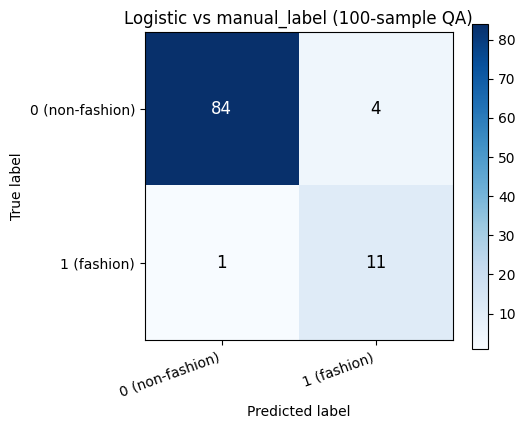


=== BERT vs manual_label ===
Accuracy: 0.91
                 precision    recall  f1-score   support

non-fashion (0)      1.000     0.898     0.946        88
    fashion (1)      0.571     1.000     0.727        12

       accuracy                          0.910       100
      macro avg      0.786     0.949     0.837       100
   weighted avg      0.949     0.910     0.920       100



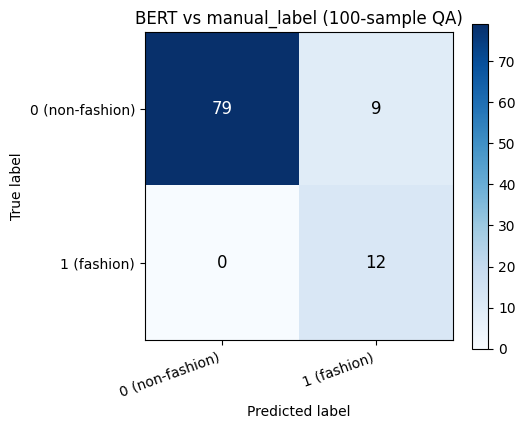

In [9]:
# Cell 1 – evaluate logistic vs BERT on 100-row unlabeled QA sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Load QA file
qa_path = PROCESSED_DATA_DIR / "manual_qa_unlabeled_logreg_vs_bert.csv"
df_qa = pd.read_csv(qa_path)
print("Loaded QA data from:", qa_path)
print("Shape:", df_qa.shape)

# 2. Keep rows with a manual label and cast to int
df_qa = df_qa.dropna(subset=["manual_label"]).copy()
df_qa["manual_label"] = df_qa["manual_label"].astype(int)
df_qa["logreg_pred"] = df_qa["logreg_pred"].astype(int)
df_qa["bert_pred"] = df_qa["bert_pred"].astype(int)

y_true = df_qa["manual_label"].values
y_log = df_qa["logreg_pred"].values
y_bert = df_qa["bert_pred"].values

print("\nLabel distribution in QA sample (manual_label):")
print(df_qa["manual_label"].value_counts().rename({0: "0 = non-fashion", 1: "1 = fashion"}))

# 3. Helper to plot a readable confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.colorbar(im, ax=ax)

    classes = ["0 (non-fashion)", "1 (fashion)"]
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=20, ha="right")
    ax.set_yticklabels(classes)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Annotate counts in each cell
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                int(cm[i, j]),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12,
            )

    plt.tight_layout()
    plt.show()

# 4. Logistic regression vs manual_label
cm_log = confusion_matrix(y_true, y_log)
acc_log = accuracy_score(y_true, y_log)

print("\n=== Logistic baseline vs manual_label ===")
print("Accuracy:", round(acc_log, 3))
print(
    classification_report(
        y_true,
        y_log,
        digits=3,
        target_names=["non-fashion (0)", "fashion (1)"],
    )
)

plot_confusion_matrix(cm_log, "Logistic vs manual_label (100-sample QA)")

# 5. BERT vs manual_label
cm_bert = confusion_matrix(y_true, y_bert)
acc_bert = accuracy_score(y_true, y_bert)

print("\n=== BERT vs manual_label ===")
print("Accuracy:", round(acc_bert, 3))
print(
    classification_report(
        y_true,
        y_bert,
        digits=3,
        target_names=["non-fashion (0)", "fashion (1)"],
    )
)

plot_confusion_matrix(cm_bert, "BERT vs manual_label (100-sample QA)")

### On the 100-row unlabeled QA sample, the logistic TF-IDF model reached 95% accuracy (4 non-fashion items misclassified as fashion, 1 fashion item missed), while BERT reached 91% accuracy (9 non-fashion items misclassified as fashion, 0 fashion items missed). For deciding Fashion vs Non-Fashion in production, the logistic model currently better matches our priority of minimizing non-fashion items entering the fashion bucket, while BERT is stronger at never missing fashion items. 

### As next steps, we could tune BERT’s threshold and training setup, explore class-weighted or focal losses, and then consider using BERT mainly for downstream fashion sub-category classification once the initial Fashion vs Non-Fashion decision is made